**Author**:  *Rebecka Fahrni*

In [2]:
# connect to data from Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Analysis of American Congress Speeches**
---

##***Data***:

***hein-daily.zip*** and ***hein-bound.zip***from https://data.stanford.edu/congress_text#download-data Congressional Record for the 43rd-114th Congresses , the daily edition covers 97th to 114th with a time span from 1981 up to 2017, the bound edition from 1873 up to 2011



##***Questions investigated:***

*   During the time of wars (proxy wars during cold war), more specifically the iraq war which resulted out of the end of the cold war, what topics were dscussed during that time ? 

*   Do the party-members discuss different topics or  were the topics similar across all parties ?  

*   When we look into the districts can we see a difference in opinion (topic) of the USA ? 



##***Background***: 
The cold war period was spanning from 12. März 1947 up to 26. Dezember 1991 during that time many important events happened that changed the world, like for example the proxy wars. 

Because the hein-daily set has better data from 1990's we either look into the afghanistan war (2001-2021) 
 or irak war (2003-2011). But because in the afghanistan war wasn't really done by 2021 and still held until 2021 a lot of US soldiers, we decide to look more into the irak war.

##***Method***:


*   Topic Modelling: 
      *    Because all the questions are related to topic modelling
      *   use of **BERTopic** by  **"Maarten Grootendorst"**


---

For our Topic Modelling part we will also need some Metadata, for this we are using:  SpeakerMap & Descr

the ***SpeakerMap***-data is structured in the following way:

'#nr_SpeakerMap.txt' (#nr. ranging from 097-114 (hein))

>speakterid|speech_id|lastname|firstname|chamber|state|gender|party|district|nonvoting

---


### **EDA preprocessing and visualizations of SpeakerMap**


In [3]:
%%capture
!pip install bertopic
!pip install bertopic[flair, gensim, spacy, use]
!pip install lexicalrichness
!pip install textblob
!pip install sacremoses
!pip install Flair
!pip install cuml

In [4]:
import os
import numpy as np
import seaborn as sns
import glob
import pandas as pd
import nltk
import matplotlib as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
nltk.download('stopwords')
from nltk.corpus import stopwords
from bertopic import BERTopic
from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import datetime as dt


# loading the data from MyDrive 
os.chdir('/content/gdrive/')
os.chdir('/content/gdrive/MyDrive')
path = "/content/gdrive/MyDrive/hein-daily"

# concatinaging all the files of the SpeakerMaps 
all_files = glob.glob(os.path.join(path, "*SpeakerMap.txt"))
df_fs = (pd.read_csv(f,sep='|') for f in all_files)
speakersmap   = pd.concat(df_fs, axis=0, ignore_index=True)

# let's check for NAN's
speakersmap.isnull().sum()  # district     1258129 NAN's

# we won't be using district & nonvoting (voting rights) so therefore we can just delete these columns
# and we also won't be using the names because we already got their individuality by the speakerid
speakersmap.drop(['district','nonvoting','lastname','firstname'], axis=1, inplace=True)

speakersmap.head(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,speakerid,speech_id,chamber,state,gender,party
0,107112401,1070000002,S,SD,M,D
1,107115011,1070000004,S,MS,M,R
2,107115011,1070000005,S,MS,M,R


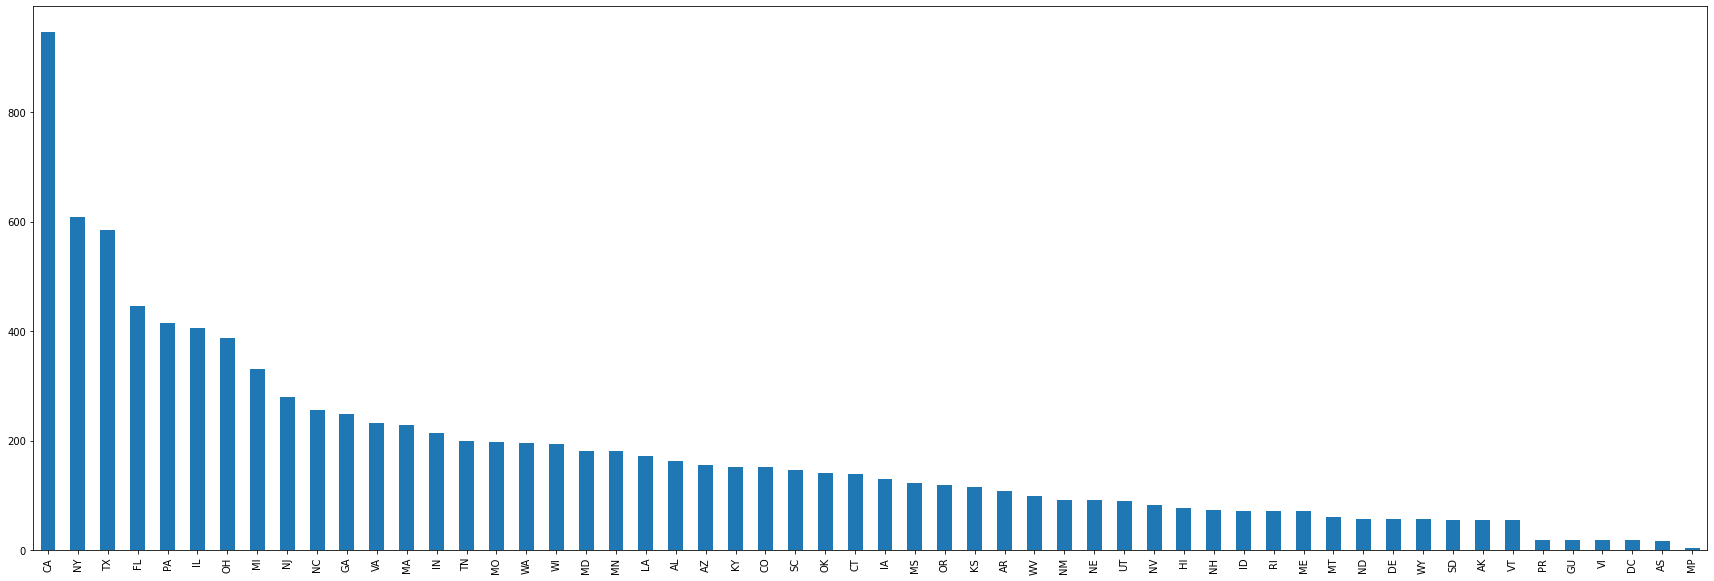

In [5]:
speakersmap.shape  # we still have a large amount of data: 2'585'807 rows 

len(speakersmap.speech_id.unique()) # as we can see the speech_id's are unique and equal to column length of the full data

len(speakersmap.speakerid.unique()) # never the less when looking into the speakerid we can see that there are only 9'845 individuals and those individuals held 2'585'807 speeches.

len(speakersmap.state.unique())  # we have 56 states 


# now we look into how many spaekers came from what state: we see that CA
diff_speakers = speakersmap.drop_duplicates(subset=['speakerid']) 

diff_speakers.state.value_counts().plot(kind='bar',figsize=(30, 10))

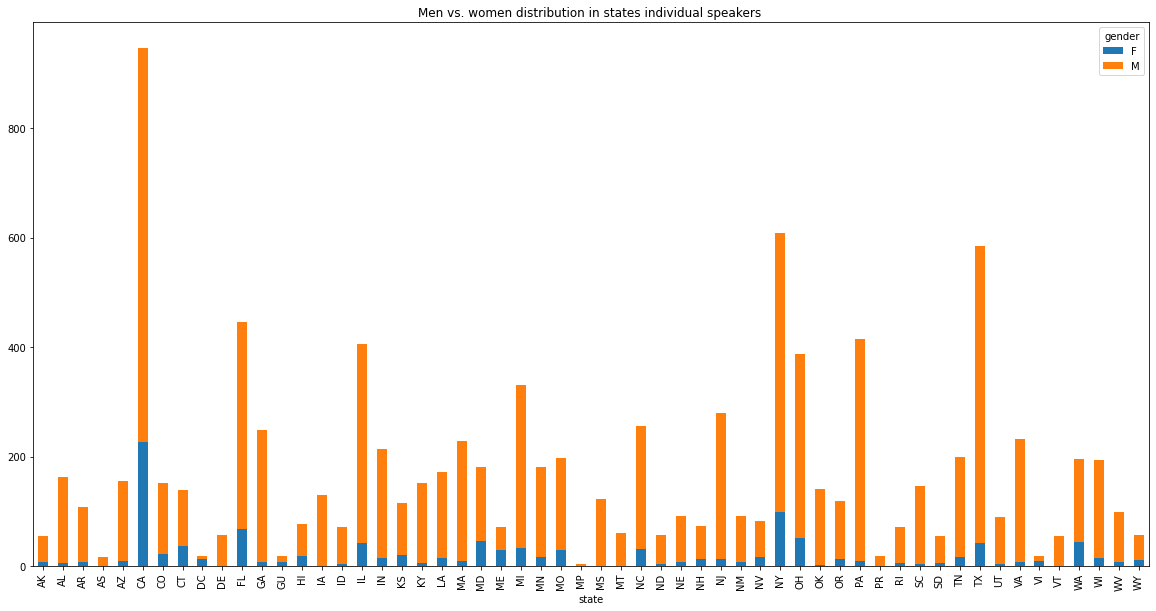

In [4]:
diff_speakers.groupby(['state', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='Men vs. women distribution in states individual speakers ')

Interestingly, in the full dataset there are way more speakers from CA(California)


In [6]:
diff_speakers= diff_speakers.loc[(diff_speakers['party'] == 'R') | (diff_speakers['party'] == 'D') ]


Because the parties: I/A/N/P are not really represented in the dataset I decide to leave them out 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


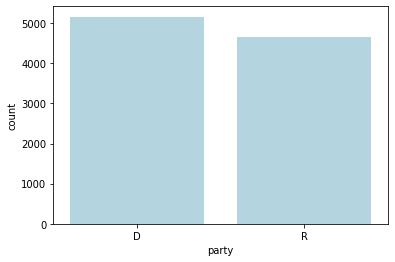

In [6]:
sns.countplot(diff_speakers['party'], color='lightblue') 

Moreover with this plot above we see the individual speakers and their D/R-party membership. We can see there are overall more  Democrates (female and men together) .
This is an uneven dataset and that needs to be kept in mind.
To prevent this unevenness we could just choose random speeches and make sure it has equal size. 
Nevertheless, because the difference is not too high for our topic model, therefore I decide to keep it. 

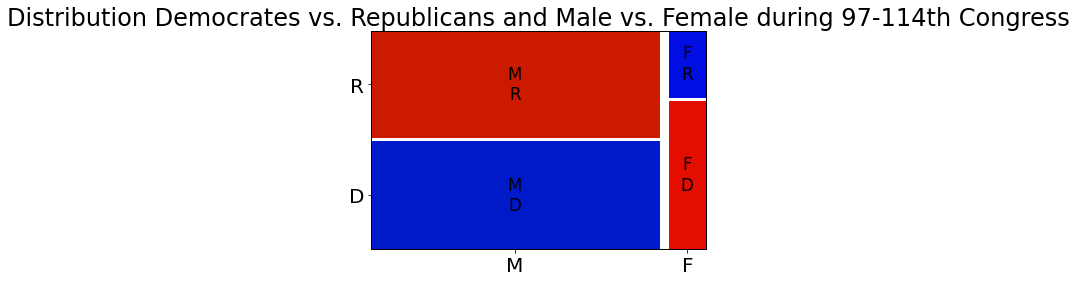

In [6]:
plt.rcParams['font.size'] = 20.0
mosaic(diff_speakers,['gender', 'party'],title= 'Distribution Democrates vs. Republicans and Male vs. Female during 97-114th Congress', gap=0.03,statistic=True)
plt.show()

With this plot we can see that the party-membership difference is larger in Females. There are more female democrates than female republicans 

Another very interesting question how many individual speeches we have devided by party and gender:

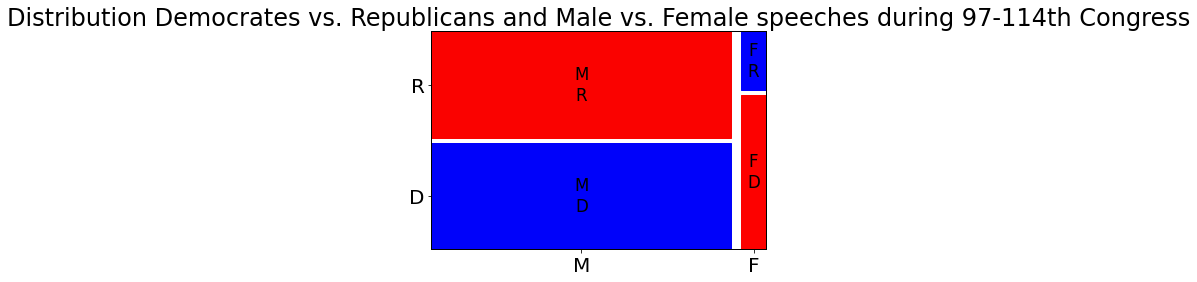

In [7]:
plt.rcParams['font.size'] = 20.0
speakersmap= speakersmap.loc[(speakersmap['party'] == 'R') | (speakersmap['party'] == 'D') ]
mosaic(speakersmap,['gender', 'party'],title= 'Distribution Democrates vs. Republicans and Male vs. Female speeches during 97-114th Congress', gap=0.03,statistic=True)
plt.show()

We now plotted the gender/party distribution of Congress speeches during 97-114th and we can see there are still have more male speakers versus female speakers more over we now see that clearly the female 'column' is more narrow than before where we just looked at the individual speakers. This means that totally more men spoke. The distribution in male democrats and male republicans ir relatively equal, so Republicans and Democratic males spoke equally much. 
Nevertheless, looking at the females we see clearly again the difference in democrats vs. republicans. 
This unequallity needs to be kept in mind when trying to do our topic models. 

In [8]:
speakersmap.head(3)

,speakerid,speech_id,chamber,state,gender,party
0,107112401,1070000002,S,SD,M,D
1,107115011,1070000004,S,MS,M,R
2,107115011,1070000005,S,MS,M,R


In [9]:
speakersmap.shape

(2578360, 6)

###**EDA preprocessing and visualizations of Descr-data**

The ***descr***-data is structured in the following way:

'descr_#nr.'  #nr. ranging from 097-114 (hein)

>speech_id|chamber|date|number_within_file|speaker|first_name|last_name|state|gender|line_start|line_end|file|char_count|word_count

In [8]:
path = "/content/gdrive/MyDrive/hein-daily"  
               
all_files = glob.glob(os.path.join(path, "descr_*.txt"))

# now there are no Nan's but they are called 'unknown' we need to filter them out
df_fs = (pd.read_csv(f,sep='|',na_values='Unknown') for f in all_files)
descr_df   = pd.concat(df_fs, axis=0, ignore_index=True)

In [9]:
descr_df.drop(['first_name','last_name','state','line_start','line_end','file','char_count','number_within_file'], axis=1, inplace=True)
# again there are a lot of columns we don't need (number within file , first_name,last_name,line_start, line_end, file,state, and charcount)
# we will though use the word_count to reduce the data set and only take speeches where the word count is relatively 'large'

# now let's set a condition to the word_count, so that speeches only with a certain length are considered -> this is also for our later topic modelling important.
descr_df.shape  # 3'866'183 rows we notice that it's larger than the speakersmap-dataset which had 2'585'807 rows 

descr_df.head(3)

,speech_id,chamber,date,speaker,gender,word_count
0,990000001,S,19850103,The VICE PRESIDENT,Special,51
1,990000002,S,19850103,The VICE PRESIDENT,Special,47
2,990000003,S,19850103,ber. A.D,M,190


In [10]:
# we can see that the gender is sometimes marked as 'special':
descr_df_special = descr_df[descr_df['gender']=='Special']
descr_df_special.head(8)
list_of_speaker_special = descr_df_special.speaker.unique()
print(len(list_of_speaker_special)) # 5491 individuals who are marked as special gender
list_of_speaker_special[:40] # we can see that The president and Vice and some other speakers were marked as specials, also some guests 'UNICEF' 

# Because of the already large dataset and the fact that 'only' 5491 were marked with a  special gender I decide to delete them:
# Nevertheless it can be debated/argued up on that decision, because the president probably held many important speeches and we are trying to topic model them at the end
# Another difficulty or a reason to cut them out is the fact that there are spealling differences see 'The CLERK', 'The Clerk'/'The VICE PRESIDENT', 'The VICE', we would need to check them with a regex formula and match them to set a gender or someting this is very time consuming.

5491


array(['The VICE PRESIDENT', 'The VICE', 'The legislative clerk',
       'The PRESIDENT pro tempore', 'The PRESIDING OFFICER',
       'The PRESIDENT', 'The PRESIDENTpro tempore',
       'The PRESIDING. OFFICER', 'The CLERK', 'The Clerk', 'The SPEAKER',
       'The SPEAKER pro tempore', 'The FEHBP', 'The FOIA', 'The ADEA',
       'The UNICEF', 'The ANNOUNCER', 'The SALT', 'The GATT', 'The ESOP',
       'The ACTING PRESIDENT pro tempore', 'The ACTING PRESIDENT',
       'The FISA', 'The PRESIDING', 'The MITI', 'The -PRESIDING OFFICER',
       'The FNCCI', 'The FDIC', 'The ICBM', 'The ACRS', 'The ERESIDING',
       'The CACS', 'The NCPP', 'The TOPS', 'The ACAP', 'The ACLU',
       'The CPDH', 'The PRESIDINGOFFICER', 'The AFL-CIO',
       'The assistant legislative clerk'], dtype=object)

In [11]:
descr_df = descr_df[descr_df['gender']!='Special']
descr_df.shape

new_df = pd.merge(descr_df, speakersmap,  how='left', on=['speech_id'])
new_df.head(10) # after merging on the speech_id we have a lot of NAN's and also unequal rows because for gender_x vs gender_y, because in one data set the gender was not specified.

# we need to do some cleaning of the Nan's. 
new_df.isna().sum().sum() # there are a lot of Nan's totally: 1526649

new_df.isnull().sum() # most Nan's are in the speakerid gender party state, I decide to delete them 

new_df.dropna(inplace=True)

# now we do some cleanup of x-y gender and chamber
new_df = new_df[(new_df['chamber_x']== 'S') &(new_df['chamber_y']=='S') | (new_df['chamber_x']== 'R') &(new_df['chamber_y']=='R')]
new_df = new_df[(new_df['gender_x']== 'M') &(new_df['gender_y']=='M') | (new_df['gender_x']== 'F') &(new_df['gender_x']=='F')]

# rename and drop columns
new_df['chamber'] = new_df['chamber_x']
new_df['gender'] = new_df['gender_x']
new_df.drop(['gender_x','gender_y','chamber_x','chamber_y'], axis=1, inplace=True)

new_df.shape # 1'247'645 rows, we still have a great amount of speech data and now we look more into them, as we get from word_count some speeches are very short example word_count = 9.

# deletion of rows with few word_count in speeches 
# I set the threshold to be 400 words
new_df = new_df[new_df['word_count']>= 400]

new_df.shape # 227'621 rows now, we lost quite many short speeches with that.

# add a column named year for later usage 
new_df['year'] = new_df.date.astype(str).str[:4].astype(int)

new_df.head(4)

,speech_id,date,speaker,word_count,speakerid,state,party,chamber,gender,year
16,990000052,19850103,Mr.. DOLE,648,99110161.0,KS,R,S,M,1985
62,990000136,19850103,Mr. DOLE,468,99110161.0,KS,R,S,M,1985
69,990000148,19850103,Mr. BYRD,492,99114621.0,WV,D,S,M,1985
74,990000156,19850103,Mr. DURENBERGER,926,99108211.0,MN,R,S,M,1985


We are only interested in Speeches during a certain time, war times, more specifically during the Irak war (2003-2011) 
I also wanted to look at the afghanistan war (1991-2021) but because we only have data until 2017 we decide to only take the irak war into consideration. 


In [12]:
war_df = new_df.loc[(new_df['year'] >= 2003 )& (new_df['year'] <=2011)]


after the merge of the two meta-data and the deletion of data we need to check again how balaced the data is in respect to party members gender ect. 

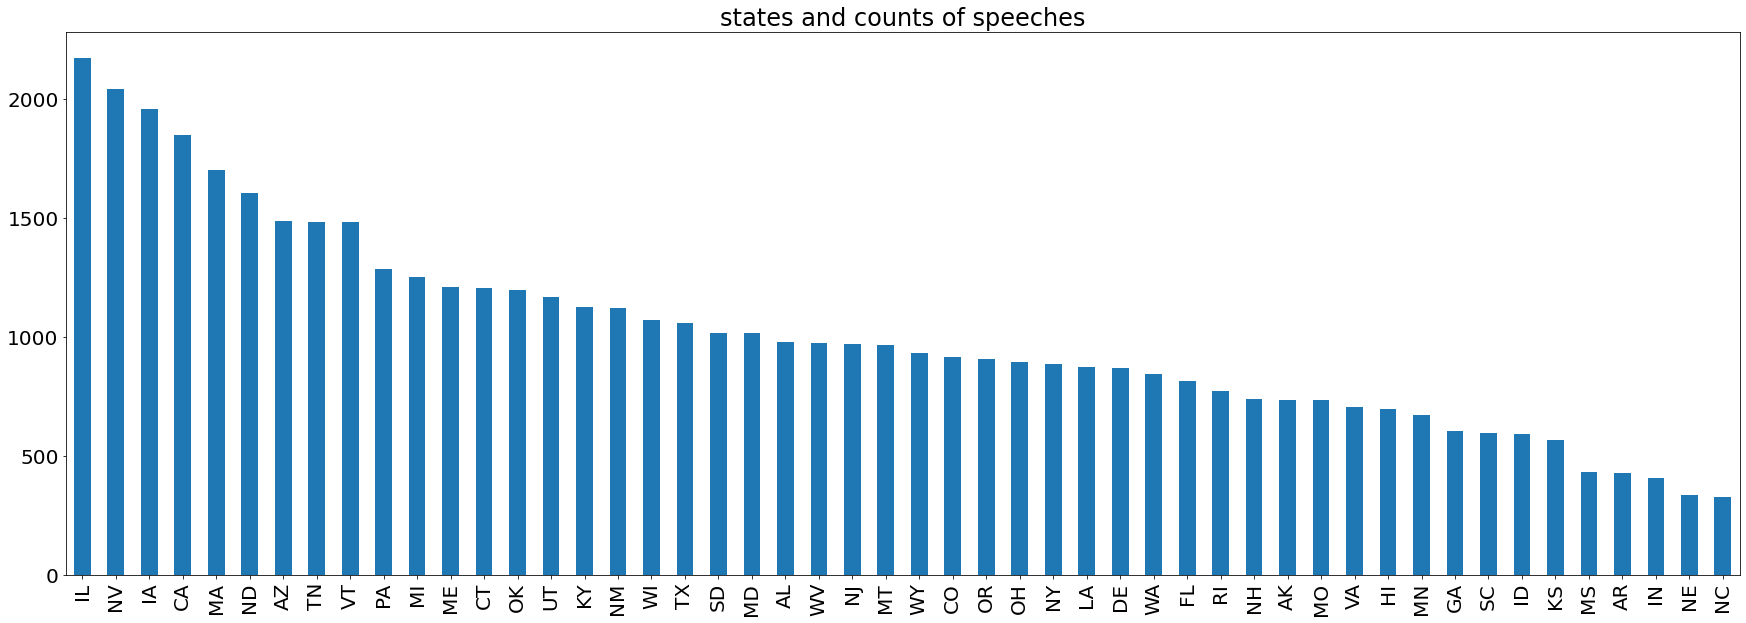

In [15]:
war_df.state.value_counts().plot(kind='bar',figsize=(30, 10),stacked=True,title='states and counts of speeches')

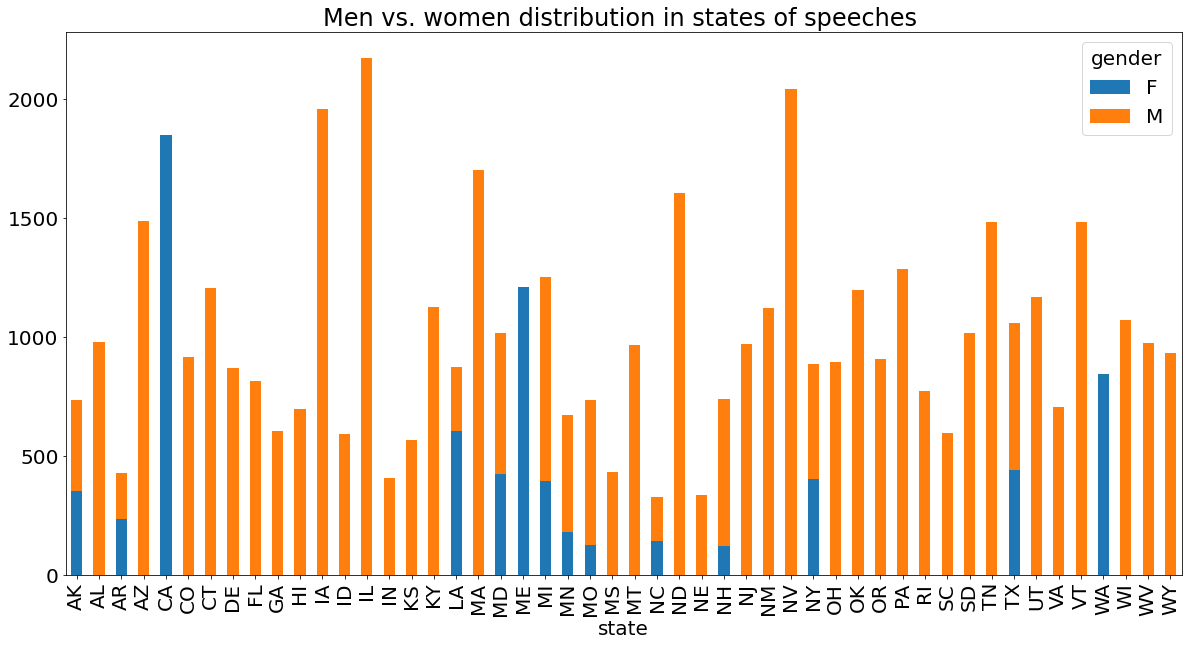

In [16]:

war_df.groupby(['state', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='Men vs. women distribution in states of speeches ')

Now, we see that CA (California) is not anymore the most represented state, but it's Illinois (IL). 
But in the plot above it's nicely visualized that most of the speeches come from women in California (CA).

This could have several causes:

```
*   We set a threshold to the  word counts of the speeches to be 400 words. So it could just mean that in CA and ME the women spoke longer speeches, not necessairly more because we removed all the shorter ones. Moreover we know that women are less represented
*   We only look at a certain year span from 2003-2011 not at individual years. so it could still mean that in a certain year more women than men spoke and on another year less. We only look at the total speeches
```



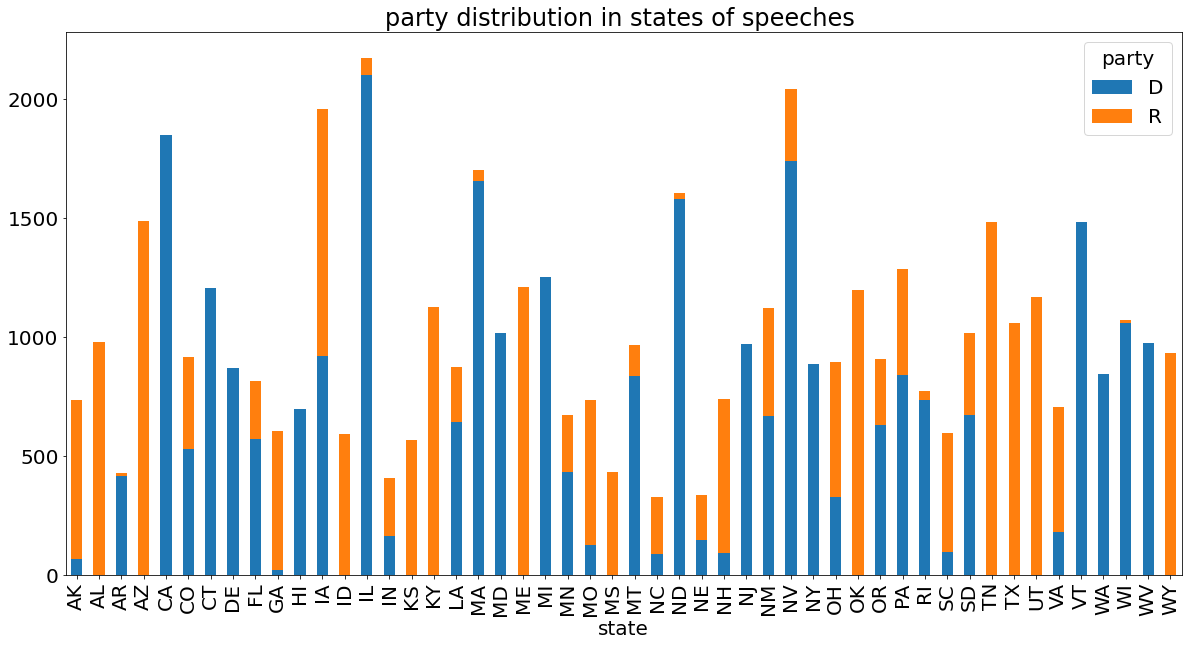

In [14]:
war_df.groupby(['state', 'party']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='party distribution in states of speeches ')

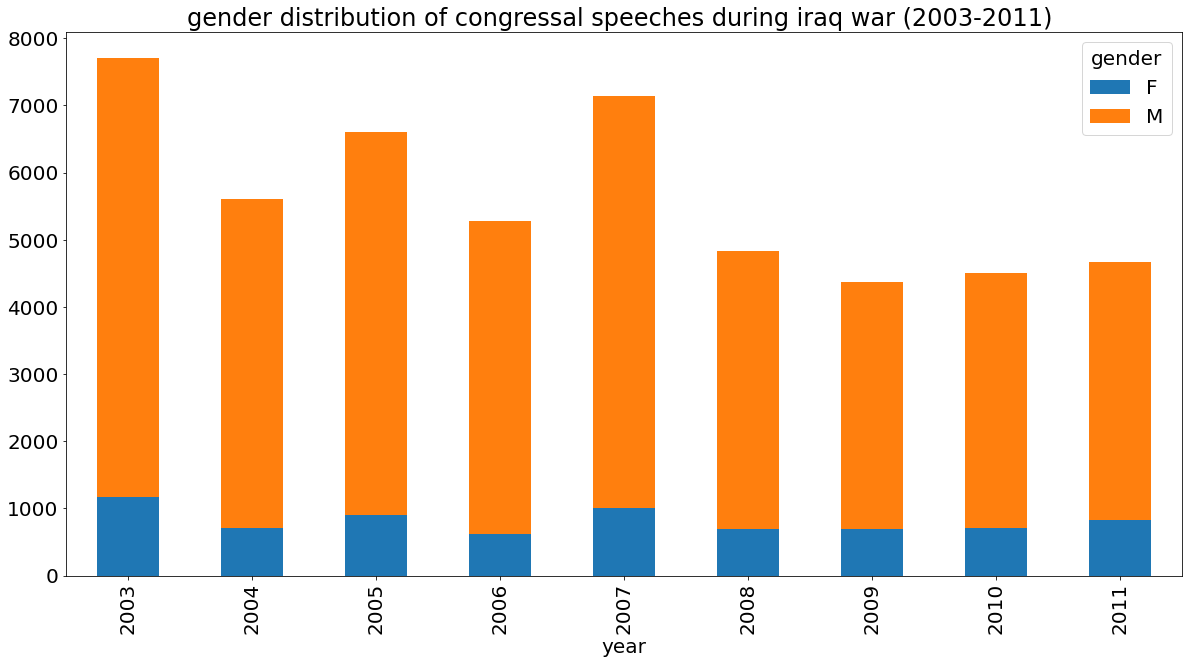

In [15]:
war_df.groupby(['year', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='gender distribution of congressal speeches during iraq war (2003-2011) ')

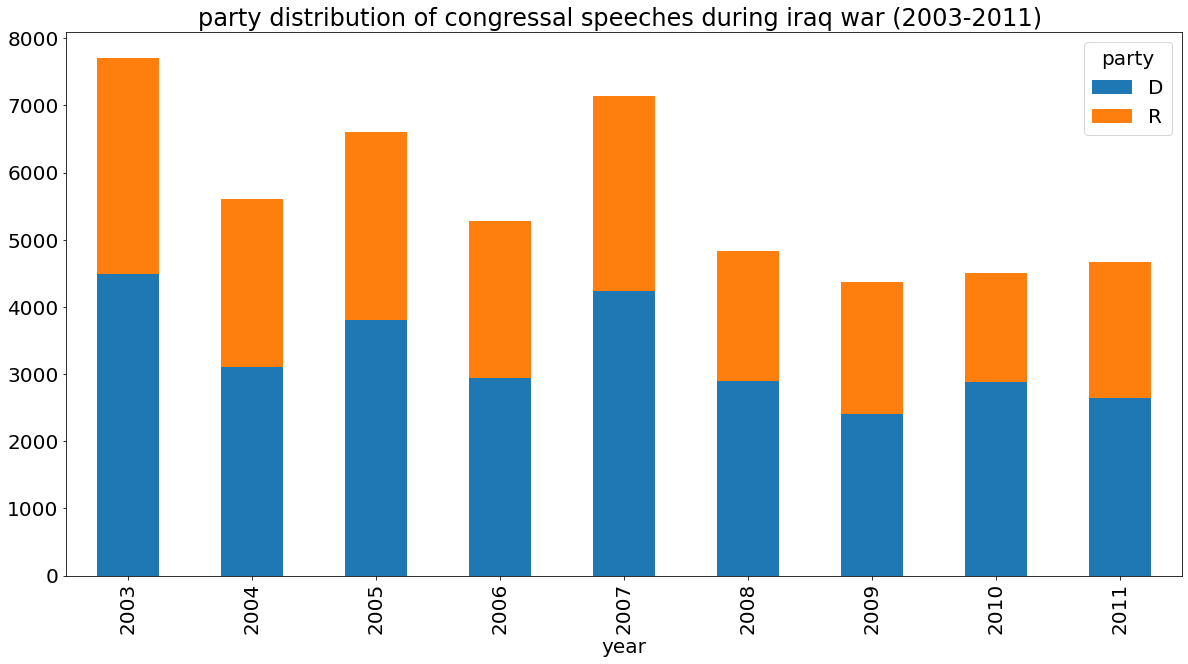

In [16]:
war_df.groupby(['year', 'party']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='party distribution of congressal speeches during iraq war (2003-2011) ')

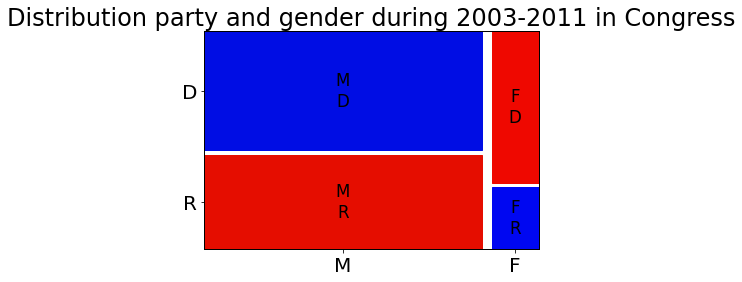

In [17]:
plt.rcParams['font.size'] = 20.0
mosaic(war_df,['gender', 'party'],title= 'Distribution party and gender during 2003-2011 in Congress', gap=0.03,statistic=True)
plt.show()

Above, we are looking at the party distribution in states of speeches, and see that overall the plot seems to have more blue = Democrats speeches than orange = republican speeches.
Moreover it is not surpixing that TX(Texas) UT (Utha) only have republican speeches. The democratic speeches in those states might have been too short and just got removed. 

Due to our hypothesis we want to look into war periods:
Nevertheless, our data begins from 1983 therefore we need to look at other wars, which resulted from the cold war. For this example we take the period from the Gulf war and Iraque war. 

Throughout the Cold War, Iraq had been an ally of the Soviet Union, and there was a history of friction between Iraq and the United States. The US was concerned with Iraq's position on Israeli–Palestinian politics. The US also disliked Iraqi support for Palestinian militant groups, which led to Iraq's inclusion on the developing US list of State Sponsors of Terrorism in December 1979.
the iraq war that lasted from 2003 to 2011. Tthe war involving ISIS that lasted from 2013 to 2017.




### **EDA and preprocessing of speech data**


The ***speeches***-data is structured in the following way:

'speeches_#nr.'
>speech_id|speech

Also here: Dataset needs to be cut in order to use it, we run out of RAM

In [13]:

path = r"/content/gdrive/MyDrive/hein-daily"                   
files = glob.glob(os.path.join(path,  'speeches_*'))


# in order to anaylise the speeches
# preprocessing is necessairy

# getting rid of non-important speeeches for example thankyou or other very short phrases

# filter out '|' in order to make the speech-ends
# the topic -> BERTopic can be used, need to get rid of stopwords
# import fnmatch
# concatinate all Speeches form 097-114th Congress -> create dataframe 
li=[]
for file in files:
    with open(file, 'r',encoding='iso-8859-1') as temp_f: #encoding='iso-8859-1'
        # get No of columns in each line
        col_count = [ len(l.split("|")) for l in temp_f.readlines() ]
        # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
        column_names = [i for i in range(0, max(col_count))]
        df = pd.read_csv(file, delimiter="|", names=column_names,low_memory=False,encoding='iso-8859-1')
        df  = df.iloc[: , :2]
        li.append(df)
    
frame = pd.concat(li, axis=0, ignore_index=True)
df_speeches = frame.rename(columns=frame.iloc[0]).drop(frame.index[0]) # replace header

print(df_speeches.shape) # very large -> too large -> 3'862'226 rows 

df_speeches['speech'].describe() 

(3862226, 2)


count                                  3862225
unique                                 2645577
top       Without objection. it is so ordered.
freq                                    116354
Name: speech, dtype: object

In [14]:
# check for dublicates short word speeches 
# some might be very similar 'congratualtions. ect'
df_speeches['speech'] = df_speeches['speech'].drop_duplicates()

# while concatinating some string ' headers' came into the dataframe need to delete them
df_speeches = df_speeches[df_speeches.speech_id != 'speech_id'] 

# now check for Nan's
print(df_speeches.isnull().sum())  # many speeches contain Nan's -> 121'6633 in total 

# I decide to remove the rows with contain 'unknown'/nan'-data
df_speeches = df_speeches.dropna(axis=0) 

speech_id          0
speech       1216633
dtype: int64


In [15]:
df_speeches.head(4)

,speech_id,speech
1,970000001,The Senate vill please come to order. The Chap...
2,970000002,The Chair lays before the Senate letters of re...
3,970000003,PR SDENT. i.he Chair lays before the Senate th...
4,970000004,If the 34 Senatorselect will now present thems...


In [27]:
war_df.head(4) # only senators 

,speech_id,date,speaker,word_count,speakerid,state,party,chamber,gender,year
1277087,1080000310,20030107,Mr. FRIST,431,108112991.0,TN,R,S,M,2003
1277088,1080000311,20030107,Mr. GRASSLEY,509,108119591.0,IA,R,S,M,2003
1277089,1080000312,20030107,Mr. SARBANES,979,108113281.0,MD,D,S,M,2003
1277090,1080000313,20030107,Ms. MIKULSKI,446,108120531.0,MD,D,S,F,2003


now we merge the meta data (during war) with the speech data 

In [16]:
# merge on speech_id

war_df['speech_id'] = war_df.speech_id.astype(int)
df_speeches['speech_id'] = df_speeches.speech_id.astype(int)


df = df_speeches.merge(war_df, on=['speech_id'], how='left')

# assure the correct
df = df[df['date'].between(20030101, 20110101, inclusive=True)]

df.shape # (45787, 11)

df['date'] = df.date.astype(int)
df['year'] = df.year.astype(int)
df['word_count'] = df.word_count.astype(int)
df['speakerid'] = df.speakerid.astype(int)

df.head()

,speech_id,speech,date,speaker,word_count,speakerid,state,party,chamber,gender,year
1889400,1080000310,Mr. President. in response to the question by ...,20030107,Mr. FRIST,431,108112991,TN,R,S,M,2003
1889401,1080000311,Mr. President. I rise today in support of exte...,20030107,Mr. GRASSLEY,509,108119591,IA,R,S,M,2003
1889402,1080000312,Mr. President. I am pleased to join my colleag...,20030107,Mr. SARBANES,979,108113281,MD,D,S,M,2003
1889403,1080000313,Mr. President. I rise in support of the Emerge...,20030107,Ms. MIKULSKI,446,108120531,MD,D,S,F,2003
1889404,1080000314,Mr. President. I rise today to urge the Senate...,20030107,Mr. FITZGERALD,657,108112451,IL,R,S,M,2003


In [17]:
rep_speech = df[df['party']=='R']
dem_speech = df[df['party']=='D']
fem_speech = df[df['gender']=='F']
mal_speech = df[df['gender']=='M']

rep_speakers = rep_speech['speakerid'].unique().tolist()
dem_speakers = dem_speech['speakerid'].unique().tolist()

# individual speakers 
len(rep_speakers)
len(dem_speakers)


print(len(mal_speech))
print(len(fem_speech))
print(len(dem_speech))
print(len(rep_speech))
# we have fewer female speeches and more male speeches and more democratic speeches than republican, for topic modelling we do some random sampling and make them eaqual in size

39322
6465
26651
19136


###**BERTopic Model**



1.   First we randomly select a certain size from the dataset, because we can not train such a large amout of data with BERT
2.   Afterwards, we do some hyperparameterization of BERTopic
3.   We visualize our findings 
4.   We try to interpret our findings



In [18]:
# we take random samples from the speeches this is due to the fact that training takes quite some time 
# this is also to make the dataset less biased towards male vs. dem speakers when topic modelling a larger dataset many more topics could arise  

rep_speech = rep_speech.sample(n=10000)
dem_speech = dem_speech.sample(n=10000)
fem_speech = fem_speech.sample(n=6465) #we only have few female speeches anyways. 
mal_speech = mal_speech.sample(n=10000)

In [19]:
# we now create 4 documents out of the 4 and do 4 individual topic modellings using bert and check for differences or similarties 
docs_rep = rep_speech['speech'].to_list()
docs_dem = dem_speech['speech'].to_list()
docs_fem = fem_speech['speech'].to_list()
docs_mal = mal_speech['speech'].to_list()

Hyperparameter settings: 

I used roberta before but got not that satisfying result, also is TFIDF better than CountVec so i use that. For stopwords i created a list and added it to the nltk stopwords 

In [20]:

# pretrained embedding model 
# roberta = TransformerDocumentEmbeddings('roberta-base') # using roBERT


# stop word removal 
stop_words = stopwords.words('english')
[stop_words.append(i) for i in ['yes','aye','no','va','our','sgt','nsf','aarp','fornia','yield','they','mr','speaker','madam','madam',
                                'amendment','oppose','chair','chairman','mister','are','mr','mrs','never','voting','forget','will','ida',
                                'mr','would','voted','000','speaker','minutes','note','pass','rules','gentleman','yea','ii','today','amend','bill'
                                ,'ask','to','claim','time','previous','question','res','we','have','our','we','the','their','and','his','is','us','he','she','agree','dr','staff','sergant','jr']]

# vectroizer use of different vectorizer 
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words,lowercase = True)
#vectorizer_model = TfidfVectorizer(ngram_range=(1, 2),lowercase=True, stop_words= stop_words) 


# this section takes quite long if not using random but we get better results ! use a GPU
# moreover use TFIDvectorizer rather than CountVectorizer -> here i use countvectorizer cause it's faster and uses less memory 

# create tf-idf sparse matrix
embeddings_rep = vectorizer_model.fit_transform(docs_rep)
embeddings_dem = vectorizer_model.fit_transform(docs_dem)
embeddings_fem = vectorizer_model.fit_transform(docs_fem)
embeddings_mal = vectorizer_model.fit_transform(docs_mal)

# for later training of topic models we specify the BERTopic-object and do some hypertuning/parameter settings (here we could also specify what clustering method we want to use -> defalt is umap and better than pca so i leave it )
topic_model_rep = BERTopic(verbose=True, language='English')
topic_model_dem = BERTopic(verbose=True, language='English')
topic_model_fem = BERTopic(verbose=True, language='English')
topic_model_mal = BERTopic(verbose=True, language='English')


In [105]:
# train topic model using tf-idf embedding in Bertopic and save model to a specific file of your choice 

topics_rep, probs_rep = topic_model_rep.fit_transform(docs_rep, embeddings_rep)
topic_model_rep.save('/content/gdrive/MyDrive/hein-daily/topic_model_rep.digital') # reduced by random sample and trained with tfidfvectorizer

2022-05-18 18:58:14,262 - BERTopic - Reduced dimensionality
2022-05-18 18:58:15,017 - BERTopic - Clustered reduced embeddings


In [46]:
# train topic model using tf-idf embedding in Bertopic and save model
topics_dem, probs_dem = topic_model_dem.fit_transform(docs_dem, embeddings_dem)
topic_model_dem.save('/content/gdrive/MyDrive/hein-daily/topic_model_dem.digital') # reduced by random sample and trained with tfidfvectorizer

2022-05-18 17:56:19,748 - BERTopic - Reduced dimensionality
2022-05-18 17:56:20,296 - BERTopic - Clustered reduced embeddings


In [112]:
# train topic model using tf-idf embedding in  Bertopic and save model 
topics_fem, probs_fem = topic_model_fem.fit_transform(docs_fem, embeddings_fem)
#topic_model_fem.save('/content/gdrive/MyDrive/hein-daily/topic_model_fem3.digital') # all tfidf
topic_model_fem.save('/content/gdrive/MyDrive/hein-daily/topic_model_fem.digital') # # reduced by random sample and trained with tfidfvectorizer

2022-05-18 19:09:19,843 - BERTopic - Reduced dimensionality
2022-05-18 19:09:20,242 - BERTopic - Clustered reduced embeddings


In [21]:
# train topic model using tf-idf embedding in Bertopic and save model
topics_mal, probs_mal = topic_model_mal.fit_transform(docs_mal, embeddings_mal)
topic_model_mal.save('/content/gdrive/MyDrive/hein-daily/topic_model_mal.digital') # reduced by random sample and trained with tfidfvectorizer

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-05-18 19:55:18,743 - BERTopic - Reduced dimensionality
2022-05-18 19:55:19,301 - BERTopic - Clustered reduced embeddings


In [34]:
# load trained topic model , so that we don't have to train it again from scratch 
topic_model_rep = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_rep.digital')
topic_model_dem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_dem.digital')
topic_model_fem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_fem.digital')
topic_model_mal = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_mal.digital')

---

#**Findings and Plots of the Topic Models**

## Intertopic Distance Map, Hierarchical Cluster, Topic-Word Score and Topic over time plots

In [47]:
topic_model_dem.get_topic_info()# shows topics their associated name and their frequency=count over the whole doc

,Topic,Count,Name
0,-1,2891,-1_the_to_of_and
1,0,522,0_energy_oil_gas_fuel
2,1,410,1_iraq_war_troops_iraqi
3,2,294,2_health_care_insurance_coverage
4,3,160,3_veterans_va_care_war
...,...,...,...
155,154,11,154_haiti_haitian_aristide_elected
156,155,11,155_zimbabwe_tni_indonesian_zimbabwes
157,156,11,156_mraps_supplemental_iraq_wars
158,157,11,157_cia_white_house_president


In [48]:
topic_model_dem.get_topic(5) # words that make the topic and their probability 

[('amendments', 0.020339844226910028),
 ('we', 0.01204110337199845),
 ('bill', 0.01046988182820039),
 ('cloture', 0.009618568153144842),
 ('have', 0.009316148948291808),
 ('vote', 0.009031712720334427),
 ('on', 0.008634333188686283),
 ('do', 0.008255514372757431),
 ('be', 0.008080517479583826),
 ('going', 0.007677813885296308)]

In [49]:
topic_model_dem.visualize_topics()

We get a nice cluster of the topic and the size is associated with the importance/count/frequency in the full document


In [88]:
topic_model_dem.visualize_barchart(top_n_topics=5, n_words=5)

In [54]:
topic_model_dem.visualize_hierarchy(topics=[0,1,3,4,8])

In [55]:
# similarity heatmap
topic_model_dem.visualize_heatmap(topics =[0,1,3,4,8])

In [56]:
topic_model_dem.get_topic(1) # topics on iraq

[('iraq', 0.021567046747068636),
 ('war', 0.010882376630327189),
 ('troops', 0.010212398884479177),
 ('iraqi', 0.009674296234243897),
 ('our', 0.007204840306648385),
 ('we', 0.0068964104522783315),
 ('the', 0.006294735808432515),
 ('in', 0.006192388046368793),
 ('forces', 0.006045106127405742),
 ('is', 0.005899736802836835)]

In [28]:
from time import time
# get timestamp
def get_timestamp(df):
  df['time'] = pd.to_datetime(df.date,format='%Y%m%d')
  list_timestamps = df['date'].to_list()
  time_list = df.time.to_list()
  spee = df.speech.to_list()
  return time_list

time_list_dem = get_timestamp(dem_speech)
time_list_rep = get_timestamp(rep_speech)
time_list_fem = get_timestamp(fem_speech)
time_list_mal = get_timestamp(mal_speech)

 Topic over Time plots

Some interesting insights during war time 

In [22]:

# for plots over time
topics_over_time_dem = topic_model_dem.topics_over_time(docs_dem,
                                                   topics_dem,
                                                   time_list_dem,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

topics_over_time_rep = topic_model_rep.topics_over_time(docs_rep,
                                                   topics_rep,
                                                   time_list_rep,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )
topics_over_time_mal = topic_model_mal.topics_over_time(docs_mal,
                                                   topics_mal,
                                                   time_list_mal,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )
topics_over_time_fem = topic_model_fem.topics_over_time(docs_fem,
                                                   topics_fem,
                                                   time_list_fem,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

'\n# for plots over time\ntopics_over_time_dem = topic_model_dem.topics_over_time(docs_dem,\n                                                   topics_dem,\n                                                   time_list_dem,\n                                                   nr_bins=50,\n                                                   datetime_format="%Y-%m-%d"\n                                                )\n\ntopics_over_time_rep = topic_model_rep.topics_over_time(docs_rep,\n                                                   topics_rep,\n                                                   time_list_rep,\n                                                   nr_bins=50,\n                                                   datetime_format="%Y-%m-%d"\n                                                )\ntopics_over_time_mal = topic_model_mal.topics_over_time(docs_mal,\n                                                   topics_mal,\n                                                   time_l

---


#### Democrats 

In [23]:
topic_model_dem.visualize_topics_over_time(topics_over_time_dem, top_n_topics=2)

NameError: ignored

In [ ]:
topic_model_dem.visualize_topics_over_time(topics_over_time_dem, topics=[0,1,8],normalize_frequency = True)

#### Republicans 

In [ ]:
topic_model_rep.get_topic_info()

In [ ]:
topic_model_rep.visualize_topics()

In [ ]:
topic_model_rep.visualize_barchart(top_n_topics=5, n_words=5)

In [ ]:
topics_over_time_rep = topic_model_rep.topics_over_time(docs_rep,
                                                   topics_rep,
                                                   time_list_rep,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d")

In [ ]:
topic_model_rep.visualize_topics_over_time(topics_over_time_rep, topics=[2,1,3],normalize_frequency = True)

### Female

In [ ]:
topic_model_fem.visualize_barchart(top_n_topics=10, n_words=5)

In [ ]:
topic_model_fem.visualize_topics()

In [ ]:
topic_model_fem.visualize_heatmap(topics =[0,1,3,4,8])

In [ ]:
topics_over_time_fem = topic_model_fem.topics_over_time(docs_fem,
                                                   topics_fem,
                                                   time_list_fem,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

In [ ]:
topic_model_fem.visualize_topics_over_time(topics_over_time_fem, topics=[2,1,3],normalize_frequency = True)

---

### Male

In [24]:
topic_model_mal.visualize_topics()

In [25]:
topic_model_mal.visualize_barchart(top_n_topics=5, n_words=5)

In [26]:
topic_model_mal.visualize_heatmap(topics =[0,1,2,3,4])

In [29]:
topics_over_time_mal = topic_model_mal.topics_over_time(docs_mal,
                                                   topics_mal,
                                                   time_list_mal,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

50it [01:06,  1.34s/it]


In [30]:
topic_model_mal.visualize_topics_over_time(topics_over_time_mal, topics=[2,1,0],normalize_frequency = True)